# Global sensitivity Analysis for PULPO

In this notebook we show the workflow for the global sensitivity analysis (GSA) in PULPO.

In [80]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../develop_test')
import stats as pulpostats
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


In [ ]:
case_study = pulpostats.RiceHuskCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name="rice_husc_test")


### 1.2. Defining the electricity showcase problem

In [ ]:
case_study = pulpostats.ElectricityCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='electricity_test')

### 1.3. Defining the Ammonia case study

In [2]:
case_study = pulpostats.AmmoniaCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='ammonia_test')


Creating Instance
Instance created
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23549 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  3854302129.3511605


## Total Impact(s)

,Weight,Value
Method,,
"('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')",1,3.854302e+09


## Choices Made

### ammonia

,Value,Capacity
Metadata,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",2.010086e+09,1.000000e+20


### methane_market

,Value,Capacity
Metadata,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",2.095478e+09,1.000000e+20
market for bio methane | methane | RER,2.092156e+08,1.000000e+20


### hydrogen_market

,Value,Capacity
Metadata,,
"market for hydrogen, gaseous, low pressure | hydrogen, gaseous, low pressure | RER",2.034759e+08,1.000000e+20
market for hydrogen | hydrogen | RER,1.503000e+08,1.000000e+20


### ammonia_market

,Value,Capacity
Metadata,,
market for ammonia | ammonia | RER,3.000128e+09,1.000000e+20


### hydrogen

,Value,Capacity
Metadata,,
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",150000000.0,150000000.0
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",300000.0,300000.0


### heat

,Value,Capacity
Metadata,,
heat from methane | heat from methane | RER,7.854816e+09,1.000000e+20
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.400000e+09


### biomethane

,Value,Capacity
Metadata,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.351234e+08,1.000000e+20
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07


## Constraints

### Constraints Upper

,Key,Metadata,Value,Limit
ID,,,,
23532,"(ammonia-reduced, a2610a42cd93afb46b13b2e95273...","anaerobic digestion of animal manure, with bio...",360000000.0,360000000.0


## 2. Filtering out negletable uncertain parameters

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

In [22]:
paramfilter = pulpostats.ParameterFilter(
    result_data=result_data, 
    lci_data=case_study.pulpo_worker.lci_data, 
    choices = case_study.choices,
    demand = case_study.demand,
    method = case_study.method
    )

Using the basic scaling vector which only includes the optimal choices in the scaling vector

In [23]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='naive')

Using the scaling vector constructed from all choices

In [24]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='constructed_demand')

Compute the LCA scores and return the characterized inventory to be used for the filtering

In [25]:
lca_score, characterized_inventory = paramfilter.compute_LCI_LCIA(scaling_vector_series)

chosen environmental impact method: ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
The total impact is: 5.391816e+01


Plot the largest contributors

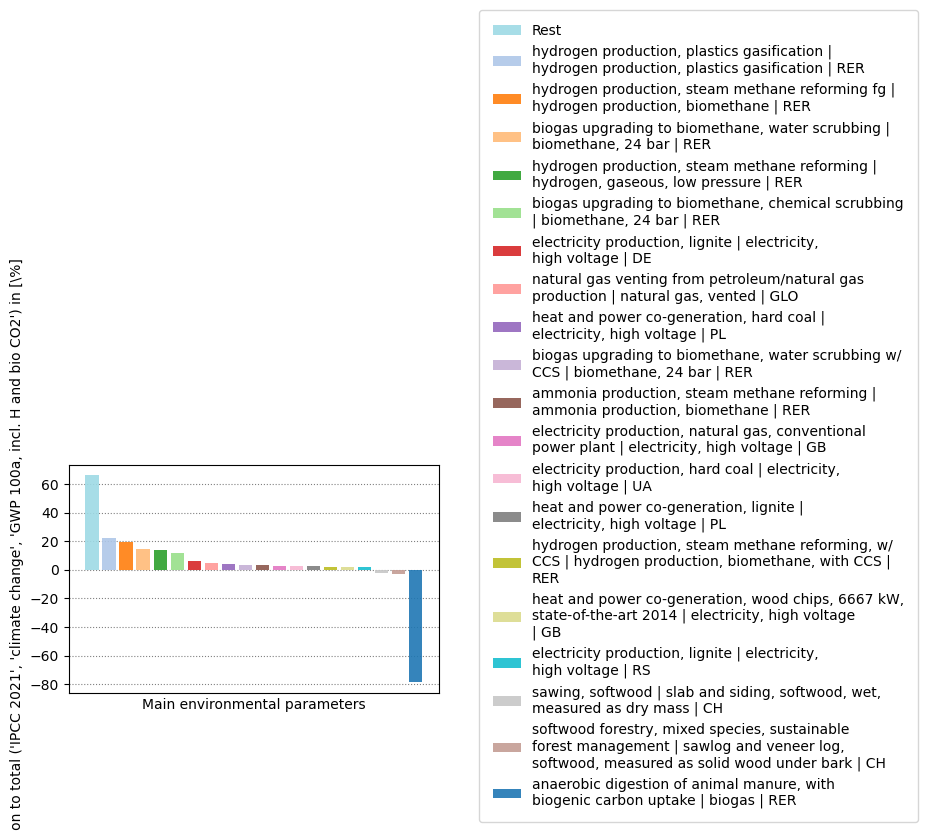

In [29]:
paramfilter.plot_top_processes(characterized_inventory, top_amount=19)

Filtering out the inventoryflows $B_{i,j}$ that have a neglectable impact

In [34]:
cutoff = 0.00002
filtered_inventory_indcs = paramfilter.filter_inventoryflows(characterized_inventory, lca_score, cutoff)

Characterized inventory: (2648, 23557) 26580
Filtered characterized inventory: (2648, 23557) 982
Deviation from LCA score: 0.009995784029205534
inventory (2648, 23557) filtering resulted in 982 of 26580 exchanges (99.0% of total impact) and took 0.003 seconds.


In [35]:
filtered_characterization_indcs = paramfilter.filter_characterization_factors(filtered_inventory_indcs)

CHARACTERIZATION MATRIX (2648,) filtering resulted in 27 of 111 characterization factors


## 3. Getting the uncertainty of the parameter values

### 3.1. Interventions flows

Extract the metadata containing the uncertainty information to the filtered intervention flows and seperate the metadata into the parameters with and without defined uncertainty information

In [84]:
uncertainty_importer = pulpostats.UncertaintyImporter(lci_data=case_study.pulpo_worker.lci_data)
backgroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ecoinvent-3.10-cutoff', filtered_inventory_indcs)
foregroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ammonia-reduced', filtered_inventory_indcs)
bg_inventory_metadata_df = uncertainty_importer.get_intervention_meta(inventory_indices=backgroundDB_filtInv_indcs)
fg_inventory_metadata_df = uncertainty_importer.get_intervention_meta(inventory_indices=foregroundDB_filtInv_indcs)
bg_inventory_defined,  bg_inventory_undefined = uncertainty_importer.separate(bg_inventory_metadata_df)
fg_inventory_defined,  fg_inventory_undefined = uncertainty_importer.separate(fg_inventory_metadata_df)


Parameters with uncertainty information: 863 
Parameters without uncertainty information: 93
Parameters with uncertainty information: 0 
Parameters without uncertainty information: 26


Apply the triangular strategy using bound interpolation to the missing intervention uncertainty parameters in the background database

upper spread statistics
mean: 0.9512
mode: 0    3.466758
dtype: float64
median: 0.5730
std: 1.1150
min: 0.0582
max: 8.0184


lower spread statistics
mean: 0.3923
mode: 0    0.776124
dtype: float64
median: 0.3643
std: 0.1824
min: 0.0550
max: 0.8891

The upper spread scaling factor for intervention flows is: 0.5730084852467614
The lower spread scaling factor for intervention flows is: 0.36427551829003174
uncertain parameters with negative median value:
            input  output  type  uncertainty_type      amount         loc  \
row  col                                                                    
2129 1603    3721    5966     2                 5 -186.611023 -186.611023   
     4358    3721    8721     2                 5 -493.676880 -493.676880   
     10497   3721   14860     2                 5 -493.676880 -493.676880   
     11086   3721   15449     2                 5 -648.320374 -648.320374   
     17241   3721   21604     2                 5 -186.469284 -186.469284   
     2

/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1040: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.322629157403707' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_fac * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1041: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7572749624168806' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_fac * abs(amount)


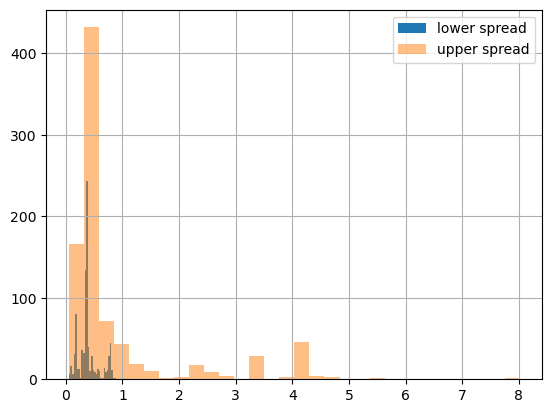

In [93]:
if_bg_triangular_strategy = pulpostats.TriangularBoundInterpolationStrategy(
    metadata_df=bg_inventory_metadata_df,
    defined_uncertainty_metadata=bg_inventory_defined,
    undefined_uncertainty_indices= bg_inventory_undefined,
    noise_interval={'min':.1, 'max':.1}
    )

Apply the Uniform strategy for the uncertainty parameters in the foreground database

In [109]:
if_fg_uniform_strategy = pulpostats.UniformBaseStrategy(
    metadata_df=fg_inventory_metadata_df,
    defined_uncertainty_metadata=fg_inventory_defined,
    undefined_uncertainty_indices=fg_inventory_undefined,
    upper_scaling_factor = .5,
    lower_scaling_factor = .5,
    noise_interval={'min':.2, 'max':.2}
)

/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:945: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.6514854571345037' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_factor * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:946: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.237624631213885' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  elif amount < 0:


### 3.2. Characterization factors

Extract the metadata containing the uncertainty information to the filtered characterization factors and seperate the metadata into the parameters with and without defined uncertainty information

In [96]:
characterization_metadata_df = uncertainty_importer.get_cf_meta(
    characterization_indices=filtered_characterization_indcs,
    method=case_study.method
    )
cf_defined,  cf_undefined = uncertainty_importer.separate(characterization_metadata_df)

Parameters with uncertainty information: 0 
Parameters without uncertainty information: 27


Apply the triangular strategy using predefined scaling factors to the missing uncertainty parameters

In [97]:
upper_scaling_factor_cf = 0.15
lower_scaling_factor_cf = 0.15
cf_triangular_strategy = pulpostats.TriangluarBaseStrategy(
    metadata_df=characterization_metadata_df,
    defined_uncertainty_metadata=cf_defined,
    undefined_uncertainty_indices=cf_undefined,
    upper_scaling_factor = upper_scaling_factor_cf,
    lower_scaling_factor = lower_scaling_factor_cf,
    noise_interval={'min':.1, 'max':.1}
)

uncertain parameters with negative median value:
      flow  geo         col  uncertainty_type  amount  loc  scale  shape  \
row                                                                        
81     108    1  4294967295                 5    -1.0 -1.0    NaN    NaN   
2129  3721    1  4294967295                 5    -1.0 -1.0    NaN    NaN   

       minimum   maximum  negative  
row                                 
81   -1.156698 -0.843302      True  
2129 -1.152857 -0.847143      True  


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1040: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1490582881843858' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_fac * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1041: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8509417118156142' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_fac * abs(amount)


## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters

Check if all parameters have gotten uncertainty information asigned

In [112]:
unc_metadata = {
    'cf': cf_triangular_strategy.metadata_assigned_df,
    'if': pd.concat([if_fg_uniform_strategy.metadata_assigned_df, if_bg_triangular_strategy.metadata_assigned_df])
}

In [117]:
from SALib.sample import sobol as sample_method
from SALib.analyze import sobol as SA_method
N = 2**3

gsa = pulpostats.GlobalSensitivityAnalysis(
    result_data=result_data,
    lci_data=case_study.pulpo_worker.lci_data,
    unc_metadata=unc_metadata,
    sampler=sample_method,
    analyser=SA_method,
    sample_size=N,
    method=case_study.method
)
gsa_problem, all_bounds_indx_dict = gsa.define_problem()

problem includes:
982 uncertain intervention flows
27 uncertain characterization factors


In [127]:
sample_data_if, sample_data_cf = gsa.sample(gsa_problem, all_bounds_indx_dict)

The statistics of the the sample impacts: ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
count    1.616000e+04
mean     4.468596e+09
std      4.682165e+08
min      3.155210e+09
25%      4.144136e+09
50%      4.594008e+09
75%      4.815563e+09
max      5.304025e+09
dtype: float64
The deterministic impact is 1.0 : 3.854302e+09
(16160,)
the z-value of the total impact: 0.10477934386858004


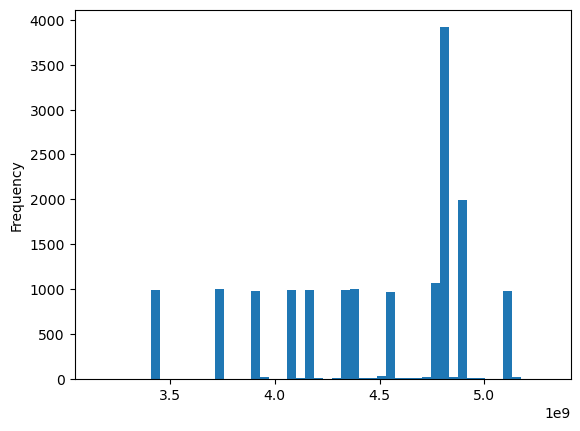

In [128]:
sample_impacts, sample_characterized_inventories = gsa.run_model(sample_data_if, sample_data_cf)

In [ ]:
total_Si = gsa.analyze(gsa_problem, sample_impacts)

/Users/hausslingbhl/miniconda3/envs/pulpo_dev/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
total_Si_metadata = gsa.generate_Si_metadata(all_bounds_indx_dict, total_Si)
colormap_base, colormap_SA_barplot = gsa.plot_top_total_sensitivity_indices(total_Si, total_Si_metadata)

In [ ]:
data_plot = gsa.plot_total_env_impact_contribution(
    sample_characterized_inventories, 
    total_Si_metadata, 
    colormap_base=colormap_base, 
    colormap_SA_barplot=colormap_SA_barplot,
    )

## 5. CC formulation

Formulate the chance constrain optimization problem. 

In the future multiple formulations might be possible, represented by different `CCFormulation` classes

In [ ]:
cc_formulation = pulpostats.CCFormulationObjIndividualNormalL1(
    unc_metadata=unc_metadata,
    pulpo_worker=case_study.pulpo_worker,
    method=case_study.method,
    choices=case_study.choices,
    demand=case_study.demand
)

Initiate epsilon solver for the Pareto Problem

In [ ]:
epsilon_pareto_solver = pulpostats.EpsilonConstraintSolver(cc_formulation)

Solve single Pareto point

In [ ]:
CC_solution = epsilon_pareto_solver.solve_single_pareto_point(lambda_level=.5)
CC_solution

Solve for an array of lambda epsilon constraints

In [ ]:
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions = epsilon_pareto_solver.solve(lambda_epsilon_array)

Plot Pareto front

In [ ]:
epsilon_pareto_solver.plot_pareto_front(CC_solutions, 0.03)

Compare the Pareto points

In [ ]:
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions)